### Notebook to check post processing pipeline. Here, inference is ran of the whole slide training image data 

In [15]:
# Import libs
import os 
import time
import cv2
from tqdm import tqdm
import numpy as np
import skimage.draw
import random
import keras
import matplotlib.pyplot as plt
import matplotlib.colors
from skimage.transform import resize

def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)

        
# Name experiment
experiment_name = "baseline"
        
# Define paths
dataset_name = "test_images" 
base_path = os.path.abspath(".")
test_dataset_path = os.path.join(base_path, "dataset", dataset_name)
log_path = os.path.join(base_path, "logs", experiment_name)
print(test_dataset_path)

# Directory of images to run detection on
IMAGES_DEST =  os.path.join(base_path, "dataset", "data_processedv0", "images/")
MASKS_DEST = os.path.join(base_path, "dataset", "data_processedv0", "masks/")

/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/test_images


In [16]:

def read_nuclei(path):
    "read raw data"

    # Load 4-channel image
    img = skimage.io.imread(path)
    
    # input image
    if len(img.shape) > 2:
        img = img[:,:,:3]
    # mask
    else:
        # do nothing
        pass
        
    return img



def save_nuclei(path, img):
    "save image"
    skimage.io.imsave(path, img)
    

Index:  196
(562, 878, 3) (562, 878)
Ground truth classes:  [0 1 2 3]


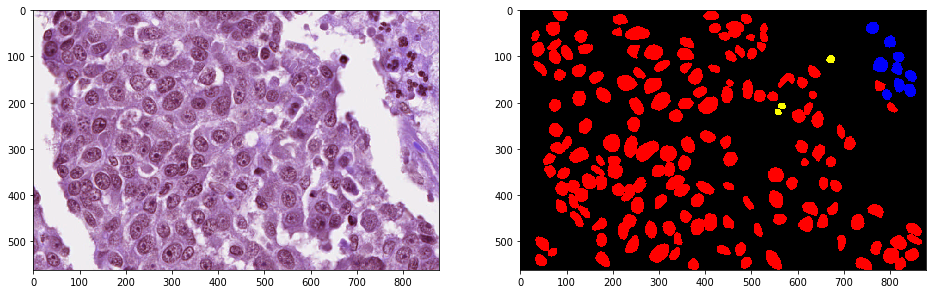

In [17]:
# Load a random image from the images folder
image_fns = sorted(next(os.walk(IMAGES_DEST))[2])
gt_fns = sorted(next(os.walk(MASKS_DEST))[2])


idx = random.randrange(len(image_fns)) # 94 
print("Index: ", idx)


image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[idx]))
gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_fns[idx]))

assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
assert image.dtype == gt.dtype, "Wrong data types!"

print(image.shape, gt.shape)

val1 = gt.flatten()
print("Ground truth classes: ", np.unique(val1))

#label_map = {'Epithelial':1,
#             'Lymphocyte':2,
#             'Macrophage':4,
#             'Neutrophil':3,
#            }

# Stolen from https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale 
norm=plt.Normalize(0,4) # 5 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])
#map_name = 'magma'

f, axarr = plt.subplots(1,2, figsize=(16,16))

# idx = 154 all classes
axarr[0].imshow(image, cmap=map_name, norm=norm)
axarr[1].imshow(gt, cmap=map_name, norm=norm)

In [18]:
#from keras.models import load_model

import efficientnet.tfkeras
from tensorflow.keras.models import load_model

model = None
model = load_model('{}/{}_model.h5'.format(log_path, experiment_name), compile=False)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [33]:
def process(image, gt, pred):
    """Plot imaage, ground truth and mask together"""
    
    f, axarr = plt.subplots(1,3, figsize=(16, 16))
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

    axarr[0].imshow(image)
    axarr[1].imshow(gt, cmap=map_name, norm=norm)
    axarr[2].imshow(pred, cmap=map_name, norm=norm)


    
def sliding_window(image, step, window):
    
    x_loc = []
    y_loc = []
    cells = []
    
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            cells.append(image[y:y + window[1], x:x + window[0]])
            x_loc.append(x)
            y_loc.append(y)
            
    return x_loc, y_loc, cells



def predict(im):
    """Predict on patch"""
    
    im = np.expand_dims(im, axis=0)
    
    im = model.predict(im)
    im = np.argmax(im.squeeze(), axis=-1)
 
    assert im.shape == (64, 64), "Wrong shape, {}!".format(im.shape)
    
    return im



def whole_slide_predict(whole_image):
    
    
    if whole_image.shape[0] < 64 or whole_image.shape[1] < 64:
        
        # Get size
        raw_dim = (whole_image.shape[1], whole_image.shape[0]) # W, H
        
        # Resize to 64x64
        whole_image_rs = cv2.resize(whole_image, (64, 64), interpolation = cv2.INTER_AREA)
        
        # Infer
        pred = predict(whole_image_rs)
        pred = pred.astype(np.uint8)
        
        # Resize back to original shape
        pred = cv2.resize(pred, raw_dim, interpolation = cv2.INTER_AREA)
        
    else:
        
        # Get locations
        x_pos, y_pos, cells = sliding_window(whole_image, 32, (64, 64))

        # Array for storing predictions
        pred = np.zeros((whole_image.shape[0], whole_image.shape[1]))

        for (x, y, cell) in zip(x_pos, y_pos, cells):

            # Get patch
            patch = whole_image[y:y + 64, x:x + 64]

            # Get size
            raw_dim = (patch.shape[1], patch.shape[0]) # W, H

            if raw_dim != (64, 64):


                # Resize to 64x64
                patch_rs = cv2.resize(patch, (64, 64), interpolation = cv2.INTER_AREA)
                assert patch.dtype == patch_rs.dtype, "Wrong data type after resizing!"


                # Do stuffffff

                processed = predict(patch_rs)
                processed = processed.astype(np.uint8)


                # Resize back to original shape
                processed = cv2.resize(processed, raw_dim, interpolation = cv2.INTER_AREA)
                
                #processed = processed.astype(np.int64) ###################
                
                assert patch.shape[:2] == processed.shape, "Wrong shape!"
                assert patch.dtype == processed.dtype, "Wrong data type in prediction!"

            else:

                # Do stuffffff

                processed = predict(patch)
                processed = processed.astype(np.uint8) 

                #print(patch.dtype, processed.dtype)

                assert patch.shape[:2] == processed.shape, "Wrong shape!"
                assert patch.dtype == processed.dtype, "Wrong data type in prediction!"


            # Add in dummy image
            pred[y:y + 64, x:x + 64] = processed 
            processed = None

    return pred


(268, 297, 3) (268, 297) (268, 297)
(900, 900, 3) (900, 900) (900, 900)


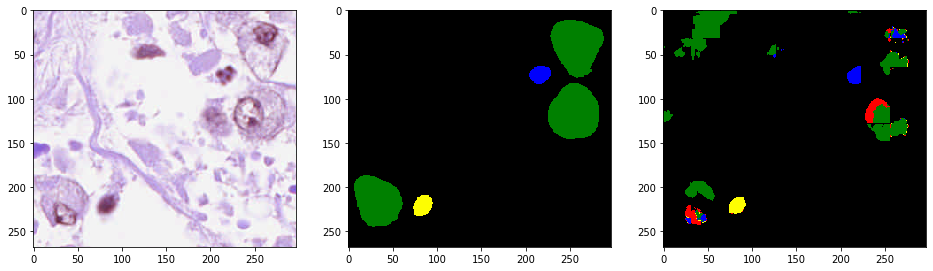

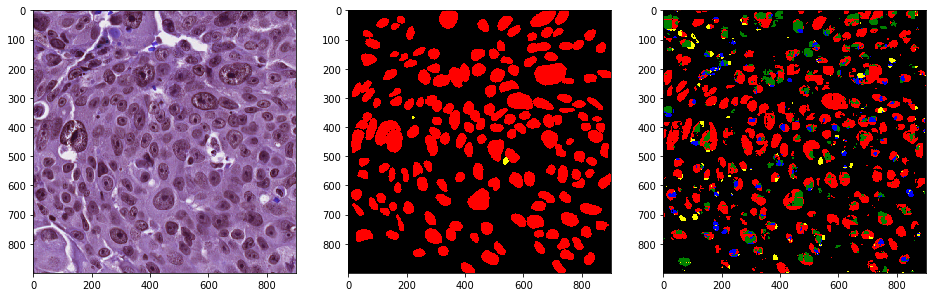

In [34]:
for i in range(2):
    
    idx = random.randrange(len(image_fns))
    #print("Index: ", idx)
    
    # Read image and ground truth
    image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[idx]))
    gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_fns[idx]))
    
    # Predict input image
    pred = whole_slide_predict(image)
    
    print(image.shape, gt.shape, pred.shape)
    
    # Display image label and prediction
    process(image, gt, pred)
    
    assert image.shape[:2] == pred.shape, "Image missmatch"